In [105]:
#%%

from music21 import *
import copy, random, math

def beat_strength(offset: float) -> int:
    # Returns 2 if on 1, 3
    # 1 if on 2, 4
    # 0 if on +
    beat = math.floor(offset)
    decimal = offset - beat
    if decimal == 0:
        return 2 if beat in [0, 2] else 1
    else:
        return 0
    
def next_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    next_map = {
        ch.root().pitchClass: ch.third,
        ch.third.pitchClass: ch.fifth,
        ch.fifth.pitchClass: ch.root(),
    }
    res = next_map[p.pitchClass].transposeAboveTarget(p)
    if res.midi == p.midi:
        res.octave += 1
    return res

def prev_chord_tone(p: pitch.Pitch, ch: chord.Chord) -> pitch.Pitch:
    prev_map = {
        ch.root().pitchClass: ch.fifth,
        ch.third.pitchClass: ch.root(),
        ch.fifth.pitchClass: ch.third,
    }
    res = prev_map[p.pitchClass].transposeBelowTarget(p)
    if res.midi == p.midi:
        res.octave -= 1
    return res

def chord_tones_above(p: pitch.Pitch, ch: chord.Chord, k: int) -> list[pitch.Pitch]:
    '''
    Return the k chord tones above and including p.
    '''
    res = [p]
    for _ in range(k - 1):
        res.append(next_chord_tone(res[-1], ch))
    return res


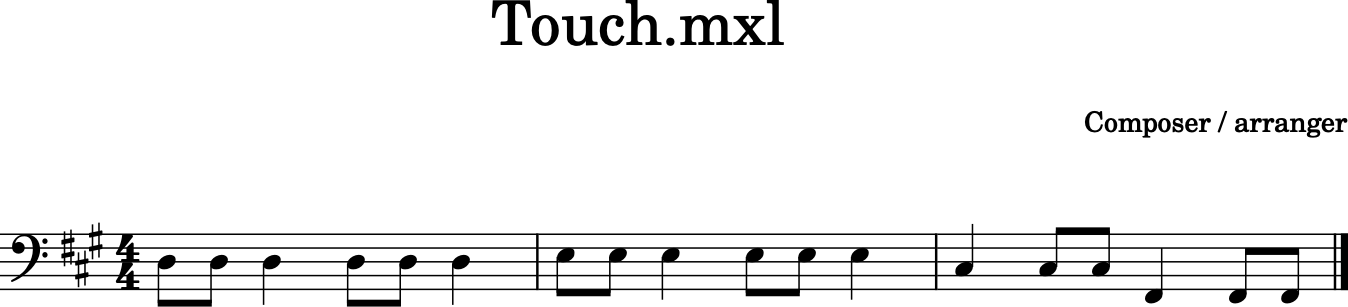

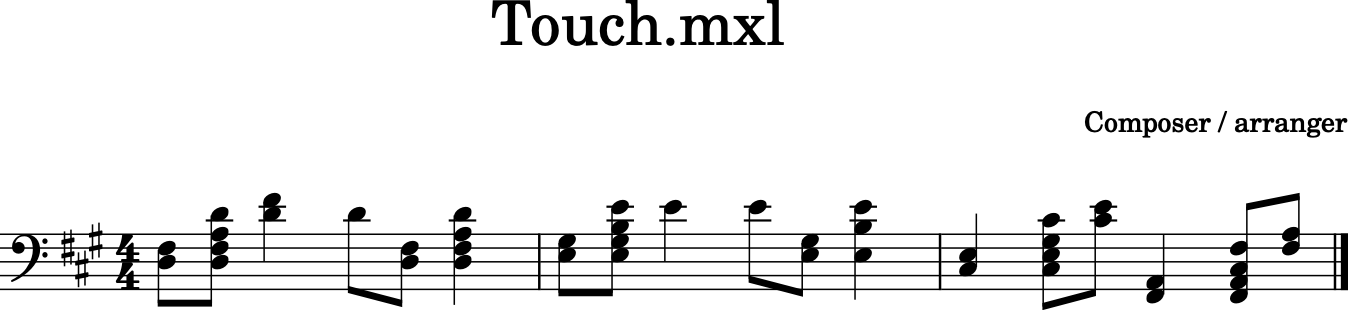

In [120]:
class BassModifier:
    def __init__(self, score_path: str):
        '''
        Takes as input a path to a score which contains the chord labels
        '''
        self.sc = converter.parse(score_path)
        self.bassline = self.sc.parts[1]
        self.key_sig = self.bassline[key.KeySignature].first()
        self.scale = self.key_sig.getScale('major')
        self.chords = {}
        self.notes = {}
        # TODO: music21 is very buggy with remove :|, so I just deduce the chords manually... 
        for n in self.bassline.flatten()[note.Note]:
            self.notes[n.offset] = n
            p = n.pitch
            self.chords[n.offset] = chord.Chord(
                [p, self.scale.nextPitch(p, stepSize=2), self.scale.nextPitch(p, stepSize=4)],
                duration=n.duration
            )
        self.measures = self.bassline[stream.Measure]
    
    
    def set_rhythm(self, n: note.Note, pattern: list[int]):
        '''
        Modifies a notes rhythm (where it is in a measure's context)
        '''
        d = n.quarterLength
        m = self.bassline.measure(n.measureNumber)
        curr_offset = n.offset # - m.offset
        # print("Starting at", offset, m.offset, n.measureNumber)
        denom = sum(pattern)
        for ix, amt in enumerate(pattern):
            new_d = amt / denom * d
            # print("Inserting", new_d, "at", curr_offset)
            if ix == 0:
                n.quarterLength = new_d
            else:
                new_n = note.Note(n.pitch, duration=duration.Duration(new_d))
                m.insert(curr_offset, new_n)
            curr_offset += new_d

    def inject_rhythm(self):
        '''
        For a loop of n chords, choose two patterns, one for first n-1, and a different
        one for the nth (to give rhythmic drive to the next loop)
        
        Currently, breaks into half-note divisions and provides one of the following
        distributions: 
        3:3:2, 3:1, 2:2, 1:1:1:1, 2:1:1, 1:1:2
        
        Operate on each half note first. Then organize which ones are special

        Todo: make more decisions on the weighting.
        '''
        # n = len(self.bassline.measures())
        # First pattern for the first n-1 measures
        weights = [4, 3, 3, 1, 3, 2]
        choices = [
            [3, 3, 2],
            [3, 1],
            [1, 1],
            [1, 1, 1, 1],
            [2, 1, 1],
            [1, 1, 2]
        ]
        rhythm_pattern = random.choices(choices, weights=weights, k=2)
        
        for m in self.measures[:-1]:
            for n in m[note.Note]:
                # Divide it by 2
                initial_split = [[1, 1], [1, 1], [2, 1, 1]]
                self.set_rhythm(n, random.choice(initial_split))
            for n in m[note.Note]:
                self.set_rhythm(n, rhythm_pattern[0])

        for n in self.measures[-1][note.Note]:
            self.set_rhythm(n, rhythm_pattern[1])
        
        self.bassline.show()

    def arpeggiate(self):
        '''
        Set more diverse pitches for the rhythms
        '''
        # Randomly shift by amounts. 
        weights = [4, 3, 2, 3, 1]
        choices = [
            0, 1, 2, 3, 4 # Root, 3rd, 5th, 8th, 10th for now.
        ]
        arpeggio_pattern = [0] + random.choices(choices, weights=weights, k=3)
        curr_chord = self.chords[0]
        chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
        pattern_pos = 0
        for m in self.measures:
            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    chord_tones = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
                    pattern_pos = 0

                # TODO: Maybe consider strong vs weak beats?
                # Cycle through the pattern for the current chord
                n.pitch = chord_tones[arpeggio_pattern[pattern_pos]]
                pattern_pos = (pattern_pos + 1) % len(arpeggio_pattern)

                
    
    
    def thicken(self):
        '''
        Expand the notes to contain more chords, upwards
        '''
        # Randomly thicken
        weights = [5, 4, 5, 2]
        choices = [
            0, 1, 2, 3 # Allow stacking from 0 to 3 notes above the bass.
        ]
        thickness_pattern = random.choices(choices, weights=weights, k=4)
        curr_chord = self.chords[0] # Start with the root guaranteed
        chord_stack = chord_tones_above(curr_chord.root(), curr_chord, len(choices))
        pattern_pos = 0

        for m in self.measures:
            for n in m[note.Note]:
                curr_offset = m.offset + n.offset 
                if curr_offset in self.chords:
                    curr_chord = self.chords[curr_offset]
                    pattern_pos = 0

                thickness = thickness_pattern[pattern_pos]
                if thickness > 0:
                    chord_stack = chord_tones_above(n.pitch, curr_chord, len(choices))
                    stack = [chord_stack[1 + i] for i in range(thickness)]
                    if random.random() <= 0.1 * thickness:
                        stack.pop(0)
                    # print("Inserting at", n.offset, *m.getElementsByOffset(n.offset), n.pitch, stack)
                    m.insertIntoNoteOrChord(n.offset, chord.Chord(stack, quarterLength=n.quarterLength))

                pattern_pos = (pattern_pos + 1) % len(thickness_pattern)

    def insert_approach_tones(self):
        '''
        Override some of the previous rhythms with approach tones in front of new chords
        '''
        # Two main techniques:
        # Single or double approach chromatic.
        # Then, we can stack that by adding the current root
        return
    
    def mutate_bass(self):
        bm.inject_rhythm()
        bm.arpeggiate()
        bm.thicken()

score_dir = '/Users/derrick/PycharmProjects/MIT/21M_383/music-melody-generator/scores/'
bm = BassModifier(score_dir + "Touch.mxl")

# list(bv.bassline.flatten()[note.Note].getElementsByOffset(4))[0].duration

# bm.bassline.show()
bm.inject_rhythm()
# bm.bassline.show()
bm.arpeggiate()
# bm.bassline.show()
bm.thicken()
bm.fix_accidentals()
bm.bassline.show()


#%%

In [121]:
# bm.bassline.show('midi')
file_path = 'output.midi'
bm.bassline.write('midi', file_path)

'output.midi'

In [91]:
c1 = chord.Chord(['C4', 'E4'])
s = stream.Stream()
s.append(note.Note('C4', quarterLength=0.5))
s.append(note.Note('D4'))
s.append(note.Note('E4'))
s.show('text')
print("_-----")
s.insertIntoNoteOrChord(0, note.Note('G3', quarterLength=0.5))
s.show('text')

{0.0} <music21.note.Note C>
{0.5} <music21.note.Note D>
{1.5} <music21.note.Note E>
_-----
{0.0} <music21.chord.Chord C4 G3>
{0.5} <music21.note.Note D>
{1.5} <music21.note.Note E>


In [75]:
score_path = '/Users/derrick/PycharmProjects/MIT/21M_383/music-melody-generator/scores/Touch.mxl'
sc = converter.parse(score_path)
bassline = sc.parts[0]
print(*sc[key.KeySignature])
# bassline.show('text')

<music21.key.KeySignature of 3 sharps> <music21.key.KeySignature of 3 sharps>


In [58]:

# bassline.measure(3).removeByClass(harmony.ChordSymbol)

# [bassline.remo(x) for x in elFilter]
bassline.show('text')

{0.0} <music21.instrument.Piano 'P1: Piano: Piano'>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note A>
    {3.0} <music21.note.Note C#>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.note.Note B>
    {3.0} <music21.note.Rest eighth>
    {3.5} <music21.note.Note E>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.note.Note C#>
    {0.75} <music21.note.Note D>
    {1.0} <music21.note.Note D>
    {1.5} <music21.note.Note C#>
    {2.0} <music21.note.Note B>
    {2.75} <music21.note.Note C#>
    {3.0} <music21.note.Note C#>
    {3.5} <music21.note.Note B>
    {4.0} <music21.bar.Barline type=final>
